# AWS Re:Invent  Autogluon Workshop
### This workshop will demonstrate a machine learning problem solved by autogluon.
* Use the documentation of autogluon and the different tutorials [here](https://auto.gluon.ai/stable/index.html).

## Context
In this workshop will use the Time Series predictor of Autogluon to forecast the number of futures Covid cases in different countries.

In [ ]:
# If running on your own computer please refer to AutoGluon installation instructions:
# https://auto.gluon.ai/stable/install.html
# This notebook assumes running in SageMaker Studio with "PyTorch 1.12 Python 3.8 CPU Optimized" kernel.
!pip3 install autogluon
!pip3 install ipywidgets

In [1]:
# Import the needed librairies
import pandas as pd
from matplotlib import pyplot as plt

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

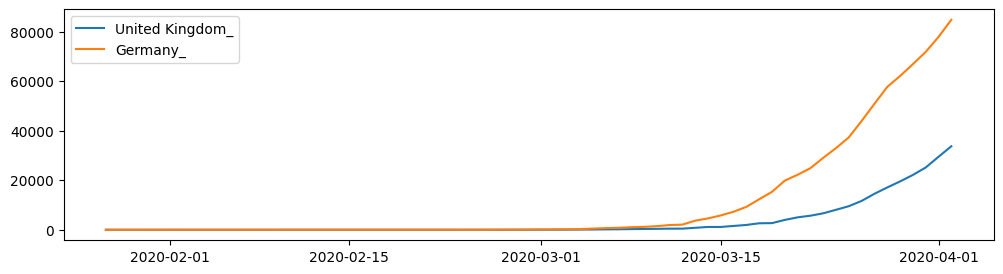

In [2]:
# We get the covid data 
df = pd.read_csv(
    "https://autogluon.s3-us-west-2.amazonaws.com/datasets/CovidTimeSeries/train.csv",
    parse_dates=["Date"],
)
# Creation of the train dataset using the TimeSeriesDataFrame.
train_data = TimeSeriesDataFrame.from_data_frame(
    df, # We give the data frame
    id_column="name", # We mention what are the id of the different time series (one for each country)
    timestamp_column="Date", # We pass the timestamp 
)

plt.figure(figsize=(12, 3))
for country in ["United Kingdom_", "Germany_"]:
    plt.plot(train_data.loc[country].iloc[5:], label=country)
plt.legend()

In [3]:
prediction_length = 5 # We will predict the next 5 days of covid cases

In [4]:
test_data = train_data.copy()
train_data = train_data.slice_by_timestep(slice(None, -prediction_length)) 
# We use the last 5 days as our testing set.

In [5]:
train_data.head()

ConfirmedCases
item_id      timestamp                 
Afghanistan_ 2020-01-22             0.0
             2020-01-23             0.0
             2020-01-24             0.0
             2020-01-25             0.0
             2020-01-26             0.0

In [7]:
predictor = TimeSeriesPredictor(
    path="autogluon-covidforecast", # Our saving path where will be all the models trained
    target="ConfirmedCases", # The label we want to predict from the data frame
    prediction_length=prediction_length, # the number of day we want to predict
    eval_metric="MAPE", # Our evaluation metric
)
predictor.fit(
    train_data=train_data, 
    time_limit=5*60 # we set 5 min for time purpose.
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'prediction_length': 5,
 'target_column': 'ConfirmedCases',
 'time_limit': 300}
Provided training data set with 20971 rows, 313 items. Average time series length is 67.0.
Training artifacts will be saved to: /home/ec2-user/SageMaker/autogluon-covidforecast
Validation data is None, will hold the last prediction_length 5 time steps out to use as validation set.

Starting training. Start time is 2022-11-29 23:52:14
Models that will be trained: ['AutoETS', 'ARIMA', 'SimpleFeedForward', 'DeepAR', 'Transformer']
Training timeseries model AutoETS. Training for up to 299.33s of the 299.33s of remaining time.
	-0.2007       = Validation score (-MAPE)
	6.39    s     = Training runtime
	28.33   s     = Validation (prediction) runtime
Training timeseries model ARIMA. Training for up to 264.2

In [8]:
predictor.leaderboard(test_data, silent=True)
# We can compare the different models 

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model ARIMA will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model ARIMA will be re-trained on newly provided data


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.126449,-0.192838,100.717510,69.499057,129.697543,5
1,ARIMA,-0.130864,-0.217444,67.448008,39.182561,24.875390,2
2,AutoETS,-0.139026,-0.200691,35.566422,28.330808,6.386951,1
3,SimpleFeedForward,-0.158146,-0.215751,1.846263,1.985689,150.072108,3
4,DeepAR,-0.291794,-0.592067,3.965394,3.796728,47.978989,4


In [9]:
predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model ARIMA will be re-trained on newly provided data


-0.12716940396378074

In [10]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model ARIMA will be re-trained on newly provided data


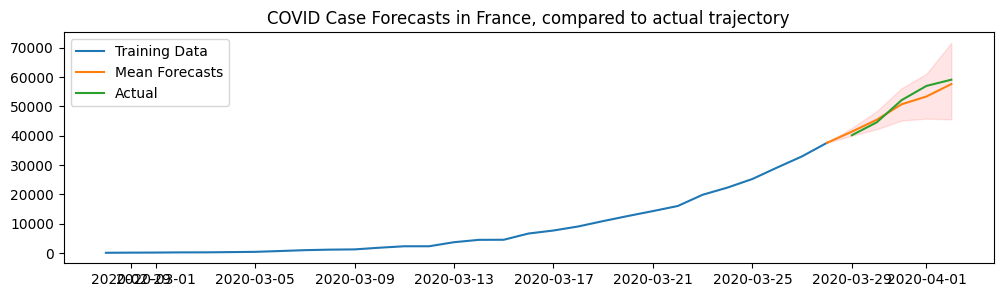

In [11]:
plt.figure(figsize=(12, 3))

ytrue = train_data.loc['France_']["ConfirmedCases"]
ypred = predictions.loc['France_']

# prepend the last value of true range to predicted range for plotting continuity
ypred.loc[ytrue.index[-1]] = [ytrue[-1]] * 10
ypred = ypred.sort_index()

ytrue_test = test_data.loc['France_']["ConfirmedCases"][-5:]

plt.plot(ytrue[-30:], label="Training Data")
plt.plot(ypred["mean"], label="Mean Forecasts")
plt.plot(ytrue_test, label="Actual")

plt.fill_between(
    ypred.index, ypred["0.1"], ypred["0.9"], color="red", alpha=0.1
)
plt.title("COVID Case Forecasts in France, compared to actual trajectory")
_ = plt.legend()